In [1]:
import numpy as np
import pandas as pd
import pygmt as gmt
import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/yohai/workspace/faultSlip/')
sys.path.append('/Users/yohai/workspace/GPS_processing/')
from utils import *
%load_ext autoreload
%autoreload 2
from faultSlip.inversion import Inversion
from faultSlip.utils import *

In [2]:
def get_disp():
    dip_slip = np.sin(np.radians(rake)) * slip
    strike_slip = np.cos(np.radians(rake)) * slip
    inv.solution = np.array([strike_slip, dip_slip])
    return inv.gps[0].save_model(inv.solution), inv
def get_plain_cords(inv):
    return np.stack([inv.plains[0].sources[0].p1, inv.plains[0].sources[0].p2, inv.plains[0].sources[0].p3, inv.plains[0].sources[0].p4])
def get_source_cords(s):
    plain_cords = np.stack([s.p1, s.p2, s.p3, s.p4])
    plain_cords_lat = origin_lat + m2dd(plain_cords[:, 1]*1e3)
    plain_cords_lon = origin_lon + m2dd(plain_cords[:, 0]*1e3, plain_cords_lat)
    return np.stack((plain_cords_lon, plain_cords_lat, plain_cords[:, 2])).T

In [3]:
lame_lambda, shear_mod = 320000.0, 320000.0

In [18]:
xx = np.linspace(0, 100, 1000)
yy = np.linspace(0, 100, 1000)
X, Y = np.meshgrid(xx, yy)
# tdf= pd.DataFrame(dict(x=X.flatten(), y=Y.flatten(), id=0,E=0,Se=0,N=0,Sn=0,U=0,Su=0, lon=X.flatten()*1e-3, lat=Y.flatten()*1e-3))
# tdf.to_csv('ttt.csv')

# Normal faulting example
## strike 180
## dip 45
## dip element = 1

In [59]:
parms = '''{
"global_parameters":
	{
	"poisson_ratio":0.25,
	"shear_modulus":30e9,
	"smooth":0.1,
	"dip_element":1,
	"strike_element":1,
    "open_element":0,
	"compute_mean":false,
	"boundary_constrained":false,
	"origin_lon":35.0,
	"origin_lat":35.0
	},
"plains":
	{
	"plain1":
		{
		"dip":40,
		"strike":180,
		"plain_cord":[50, 50, 0.01],
		"plain_length":18.05,
		"width":[30],
		"num_sub_stk":[1],
		"smooth_up":[],
		"strike_element":1,
		"dip_element":-1,
		 "total_width":30
		}
	},
"gps":
	{
	"gps_set_1":
		{
		"data":"./ttt.csv"
		}
	}
}
'''
with open('./__t.json', 'w') as f:
    f.write(parms)
inv = Inversion('./__t.json')
inv.build_kers()
inv.build_sources_mat()
plain_cords = get_plain_cords(inv)

In [60]:
E, N, Z = inv.calc_disp_2d(X, Y, np.array([0, 1]))

In [61]:
da = xr.DataArray(
    data=E,
    dims=['y', 'x'],
    coords=dict(
        y=(['y'], yy),
        x=(['x'], xx)
    )
)

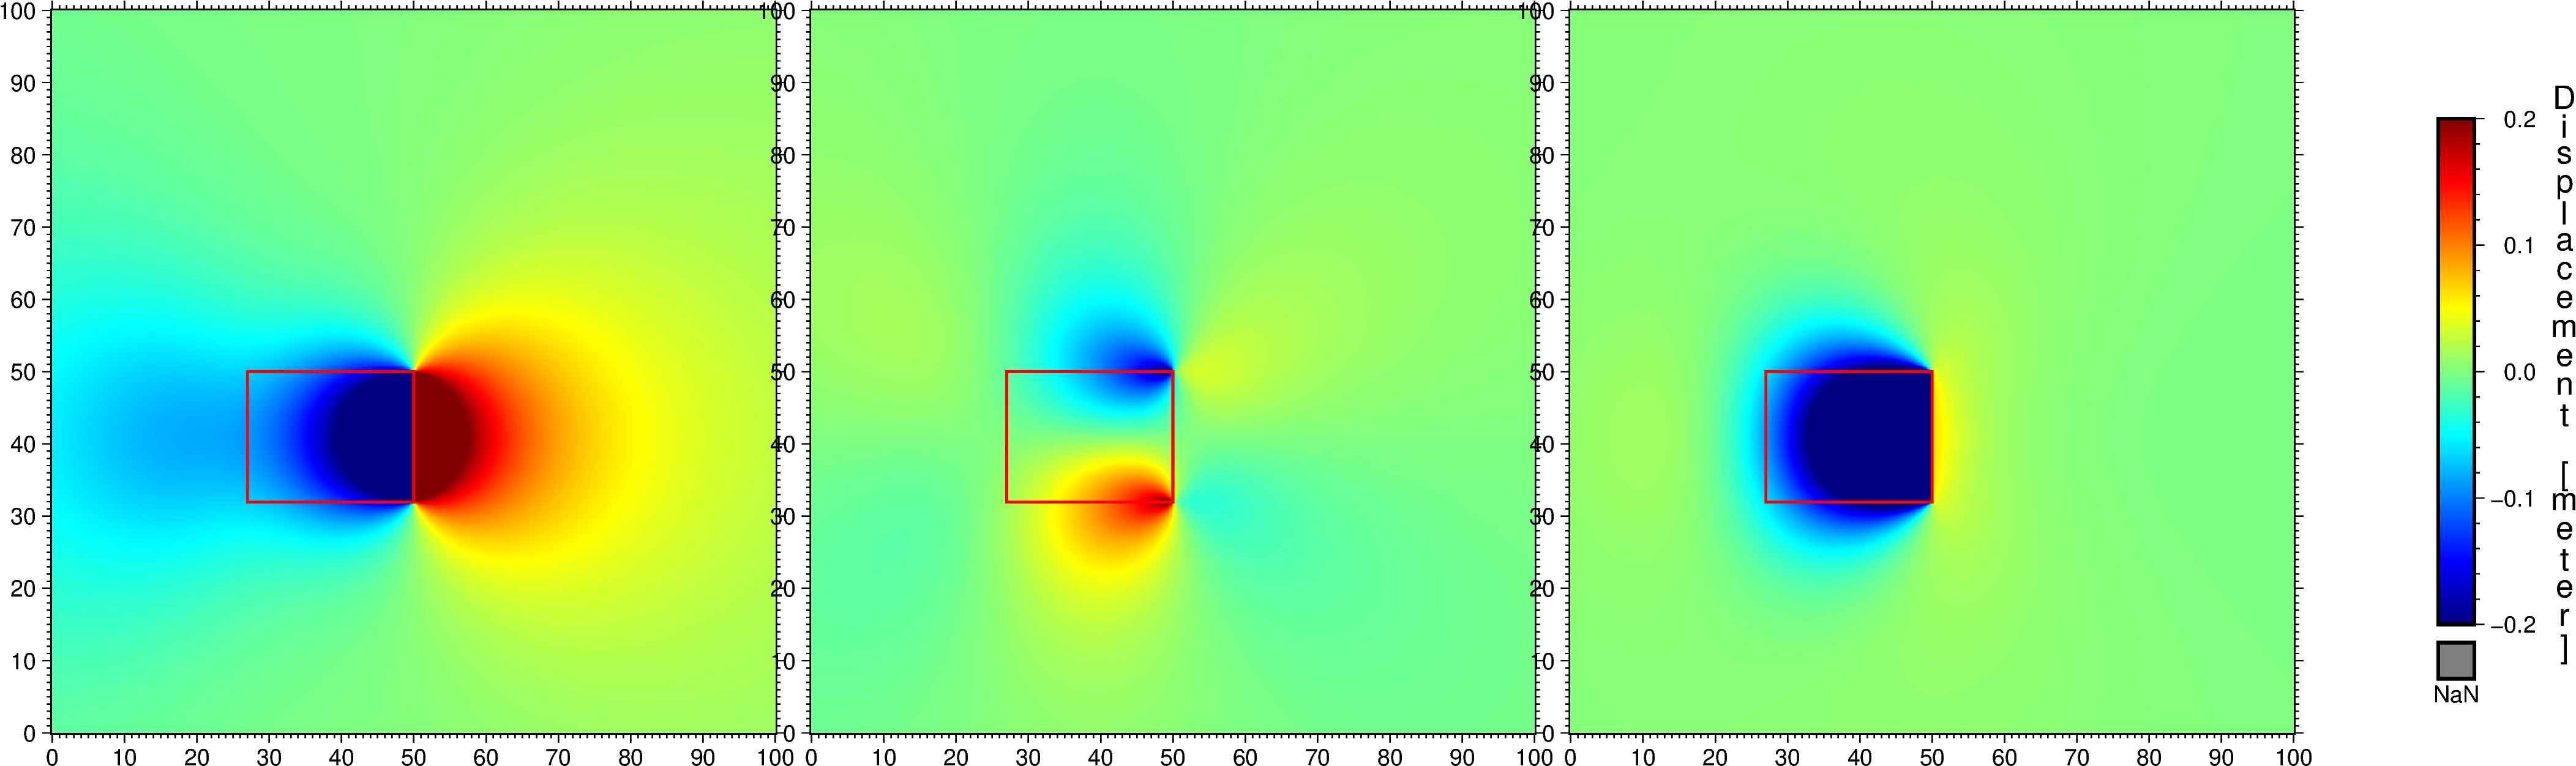

In [68]:
fig = gmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')
pygmt.makecpt(cmap="jet", series=[-0.2, 0.2, 0.001], background=True)

region=[0, 100, 0, 100]
fig.basemap(
    frame=['WSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X10",
    region=region
)
da = xr.DataArray(
    data=E,
    dims=['y', 'x'],
    coords=dict(
        y=(['y'], yy),
        x=(['x'], xx)
    )
)
fig.grdimage(grid=da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='1,red',
    close=True
)
fig.shift_origin(xshift="10.5c")
fig.basemap(
    frame=['WSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X10",
    region=region
)
da = xr.DataArray(
    data=N,
    dims=['y', 'x'],
    coords=dict(
        y=(['y'], yy),
        x=(['x'], xx)
    )
)
fig.grdimage(grid=da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='1,red',
    close=True
)
fig.shift_origin(xshift="10.5c")
fig.basemap(
    frame=['WSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X10",
    region=region
)
da = xr.DataArray(
    data=Z,
    dims=['y', 'x'],
    coords=dict(
        y=(['y'], yy),
        x=(['x'], xx)
    )
)
fig.grdimage(grid=da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='1,red',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c+n+mc", frame='af+l"Displacement [meter]"')

fig.show(width=1200)

In [69]:
flight_direction = np.radians(193.26)
incidence_angle = np.radians(90)
a1 = -np.cos(flight_direction) * E
a2 = np.sin(flight_direction) * N
a3 = Z * np.cos(incidence_angle)
D = -((a1 + a2) * np.sin(incidence_angle) + a3)

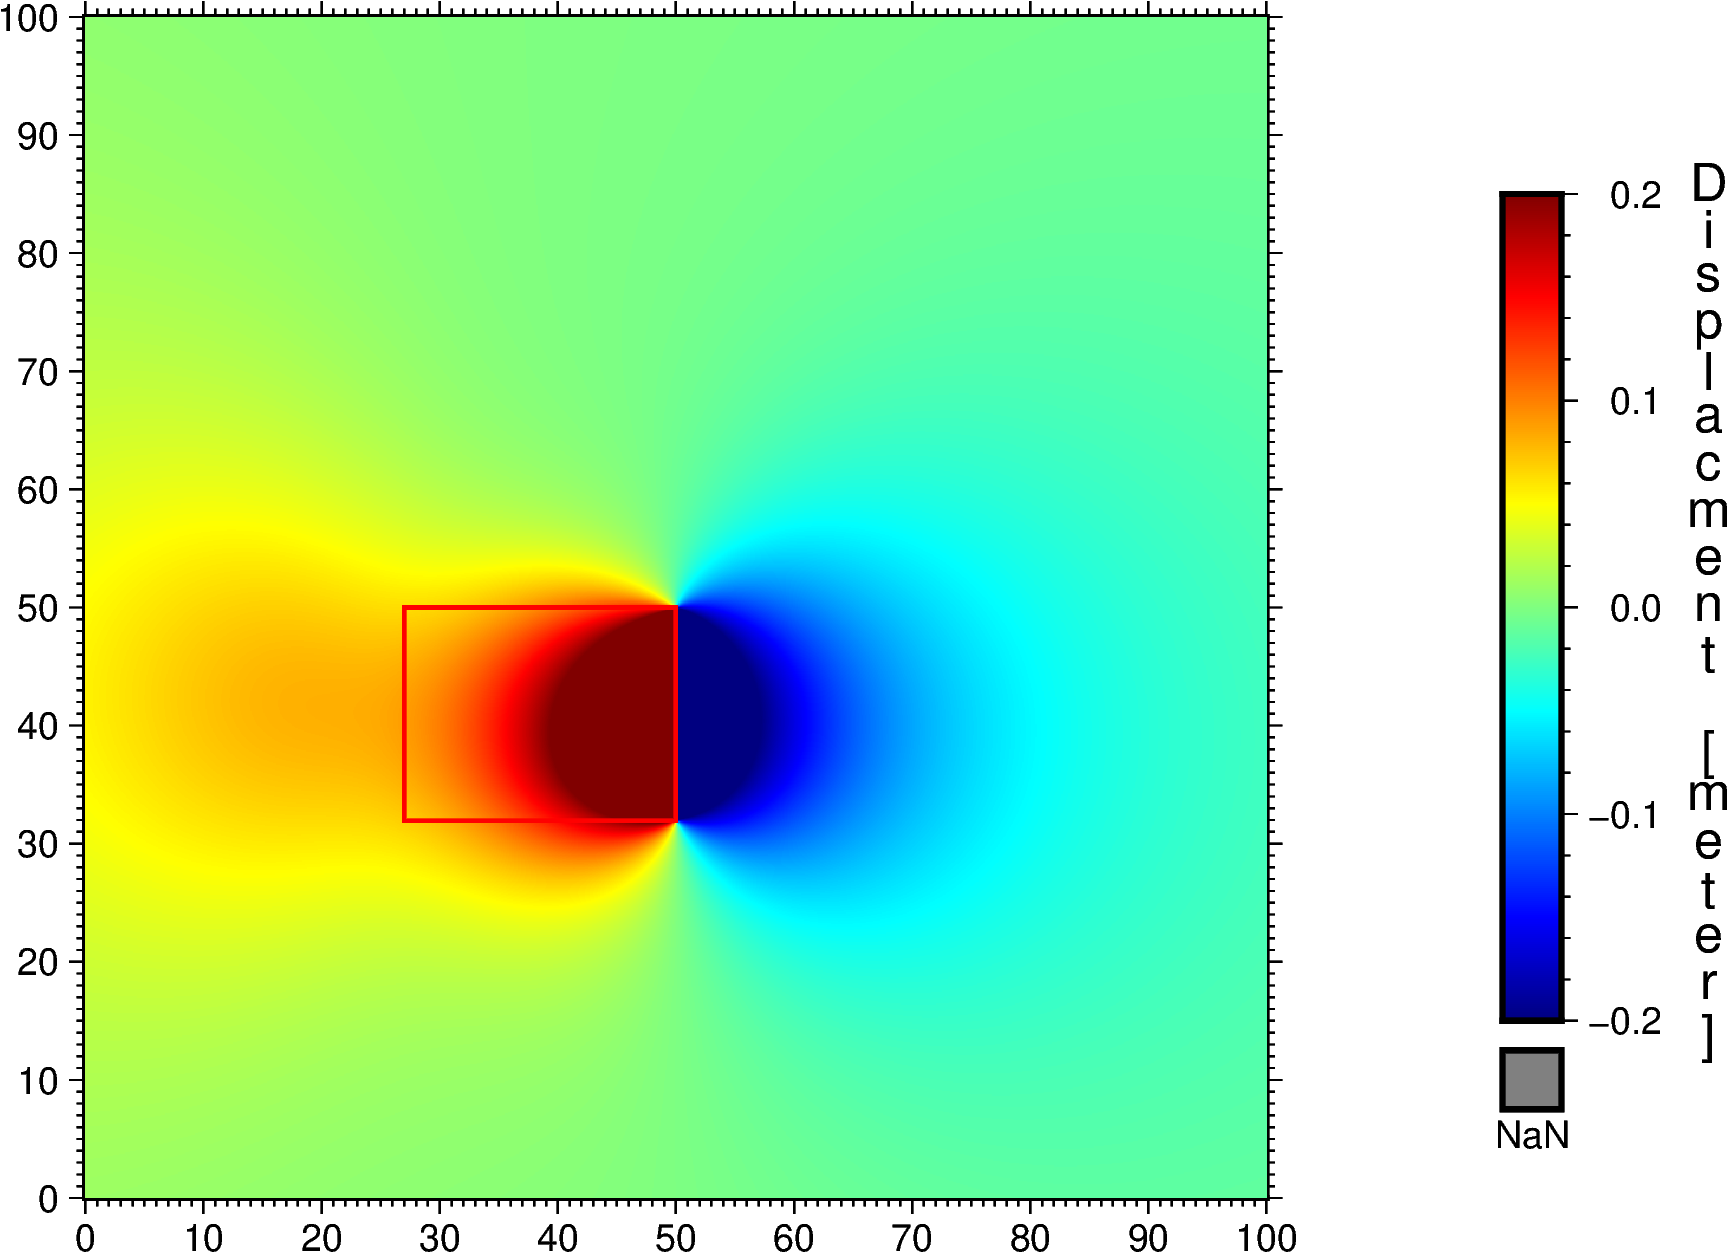

In [70]:
fig = gmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')
pygmt.makecpt(cmap="jet", series=[-0.2, 0.2, 0.001], background=True)

region=[0, 100, 0, 100]
fig.basemap(
    frame=['WSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X10",
    region=region
)
da = xr.DataArray(
    data=D,
    dims=['y', 'x'],
    coords=dict(
        y=(['y'], yy),
        x=(['x'], xx)
    )
)
fig.grdimage(grid=da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='1,red',
    close=True
)

fig.colorbar(position="JMR+o2c/0c+w7c/0.5c+n+mc", frame='af+l"Displacment [meter]"')

fig.show(width=1200)